In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical 
from keras.models import Model
import sklearn.metrics

import tensorflow as tf
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
conv1_filter = 4
conv2_filter = 4
conv3_filter = 8
conv4_filter = 8

In [3]:
x_train = np.load('./data_mike/train_features.npy')
ytrain = np.load('./data_mike/train_labels.npy')

x_val = np.load('./data_mike/val_features.npy')
yval = np.load('./data_mike/val_labels.npy')

In [4]:
xtrain = x_train[:,:,:,0]
xval = x_val[:,:,:,0]
xtrain = xtrain[:, :, :,np.newaxis]
xval = xval[:,:,:,np.newaxis]
print xtrain.shape
print xval.shape

(774, 60, 41, 1)
(65, 60, 41, 1)


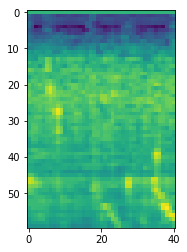

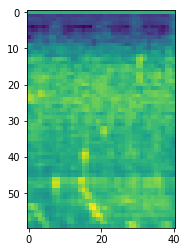

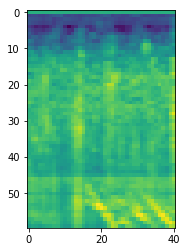

In [5]:
xtrain.shape
for i in range(3):
    plt.show(plt.imshow(xtrain[i,:,:,0]))
#     plt.show(plt.imshow(xtrain[i,:,:,1]))

In [6]:
STRIP_HEIGHT = xtrain.shape[1]
STRIP_WIDTH = xtrain.shape[2]
CHANNELS = xtrain.shape[3]
CLASSES = 4

In [ ]:
class EvaluateValidation(Callback):      
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nValidation loss: {}, acc: {}\n'.format(loss, acc))

In [ ]:
### Model ###                                                                                                                               
model = Sequential()                                                                                                                                                                      
k_init = 'he_normal'
bias_init = Constant(value=0.1)
ridge = 0.2

model.add(Convolution2D(conv1_filter, kernel_size=(5, 3), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init,
                        input_shape=(STRIP_HEIGHT, STRIP_WIDTH, CHANNELS)))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(conv2_filter, kernel_size=(10, 5), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (4, 2), strides=(2, 2), padding='valid'))

model.add(Convolution2D(conv3_filter, kernel_size=(14, 7), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(conv4_filter, kernel_size=(18, 9), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (4, 2), strides=2, padding='valid'))

model.add(Flatten())
model.add(Dense(512, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dense(256, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(CLASSES, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
model.add(Activation('softmax'))

Lr = 1e-3 
dcy = 2e-5                                                                                                                                                                                
m = 0.5
batch_sz = 25
epoch = 100
# sgd = SGD(lr=Lr, momentum=m, decay=dcy,  nesterov=True)
adam = Adam(lr=Lr, decay=dcy)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()
print('learning rate: %f, decay: %f' %(Lr, dcy))

from keras.backend import get_session
get_session().run(tf.global_variables_initializer())
a = model.fit(xtrain, ytrain, batch_size = batch_sz, epochs= epoch, verbose = 2,
              callbacks=[EvaluateValidation((xval, yval))])

loss_and_metrics = model.evaluate(xval, yval, batch_size=batch_sz)

print "Loss and accuracy: ", loss_and_metrics

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 41, 4)         64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 41, 4)         16        
_________________________________________________________________
activation_1 (Activation)    (None, 60, 41, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 41, 4)         804       
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 41, 4)         16        
_________________________________________________________________
activation_2 (Activation)    (None, 60, 41, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 20, 4)         0         
__________

In [ ]:
i = 0
for layer in model.layers:
    print "{}: {}".format(i,layer)
    i += 1

In [ ]:
def draw_weight(layer):
    filter_weights = np.array(model.layers[layer].get_weights())[0]
    channels = filter_weights.shape[2]
    num_filters = filter_weights.shape[3]
    for i in range(num_filters):
        for j in range(channels):
            plt.show(plt.imshow(filter_weights[:,:,j,i], interpolation='bilinear'))

In [ ]:
draw_weight(3)